In [1]:
import sys
sys.path = [r"C:\Users\Richard\Dropbox\dev\gon_deslib"] + sys.path
from sklearn.datasets import load_breast_cancer, load_linnerud, load_iris, load_wine, load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Perceptron
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import BaggingClassifier
from sklearn.preprocessing import LabelEncoder
#importing DCS techniques from DESlib
from deslib.dcs.ola import OLA
from deslib.dcs.a_priori import APriori
from deslib.dcs.mcb import MCB
from deslib.dcs.lca import LCA
from deslib.dcs.gon import GON
from deslib.dcs.utils import ScatterVideoCreatorGON

#import DES techniques from DESlib
from deslib.des.des_p import DESP
from deslib.des.knora_u import KNORAU
from deslib.des.knora_e import KNORAE
from deslib.des.meta_des import METADES

from deslib.static.oracle import Oracle
from deslib.util.datasets import make_P2, make_circle_square, make_banana2, make_banana

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from IPython.display import HTML

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Breast Cancer

In [2]:
data = load_breast_cancer()
X = data.data
y = data.target
# split the data into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

# Scale the variables to have 0 mean and unit variance
scalar = StandardScaler()
X_train_gon = X_train.__copy__()
y_train_gon = y_train.__copy__()
X_test_gon = X_test.__copy__()
y_test_gon = y_test.__copy__()

X_train = scalar.fit_transform(X_train)
X_test = scalar.transform(X_test)
# Split the data into training and DSEL for DS techniques
X_train, X_dsel, y_train, y_dsel = train_test_split(X_train, y_train, test_size=0.5)

models = 2
depth = 4

In [3]:
pool_classifiers = BaggingClassifier(DecisionTreeClassifier(max_depth=depth), 
                                     n_estimators=models)
_ = pool_classifiers.fit(X_train, y_train)

In [4]:
ola = OLA(pool_classifiers)
mcb = MCB(pool_classifiers)
apriori = APriori(pool_classifiers)
lca = LCA(pool_classifiers)


gon = GON(pool_classifiers=[DecisionTreeClassifier(max_depth=depth) for i in range(models)], 
          step_size=1., 
          iterations=40, 
          mode='global',
          step_callback=None)

# DES techniques
knorau = KNORAU(pool_classifiers)
kne = KNORAE(pool_classifiers)
desp = DESP(pool_classifiers)
meta = METADES(pool_classifiers)

# Standard Techs
rf = RandomForestClassifier(max_depth=depth, n_estimators=models)
gb = GradientBoostingClassifier(max_depth=depth, n_estimators=models)

In [5]:
knorau.fit(X_dsel, y_dsel)
kne.fit(X_dsel, y_dsel)
desp.fit(X_dsel, y_dsel)
ola.fit(X_dsel, y_dsel)
mcb.fit(X_dsel, y_dsel)
apriori.fit(X_dsel, y_dsel)
meta.fit(X_dsel, y_dsel)
lca.fit(X_dsel, y_dsel)
gon.fit(X_train_gon, y_train_gon) # we use no separate set to train and select
rf.fit(X_train_gon, y_train_gon)
_ = gb.fit(X_train_gon, y_train_gon)

In [6]:
print('Classification accuracy OLA: ', ola.score(X_test, y_test))
print('Classification accuracy A priori: ', apriori.score(X_test, y_test))
print('Classification accuracy KNORA-Union: ', knorau.score(X_test, y_test))
print('Classification accuracy KNORA-Eliminate: ', kne.score(X_test, y_test))
print('Classification accuracy DESP: ', desp.score(X_test, y_test))
print('Classification accuracy META-DES: ', apriori.score(X_test, y_test))
print('Classification accuracy LCA: ', lca.score(X_test, y_test))
print('Classification accuracy GON: ', gon.score(X_test_gon, y_test_gon))
print('Classification accuracy RF: ', rf.score(X_test_gon, y_test_gon))
print('Classification accuracy GB: ', gb.score(X_test_gon, y_test_gon))

Classification accuracy OLA:  0.9148936170212766
Classification accuracy A priori:  0.9148936170212766
Classification accuracy KNORA-Union:  0.8936170212765957
Classification accuracy KNORA-Eliminate:  0.8882978723404256
Classification accuracy DESP:  0.8882978723404256
Classification accuracy META-DES:  0.9095744680851063
Classification accuracy LCA:  0.9042553191489362
Classification accuracy GON:  0.9308510638297872
Classification accuracy RF:  0.925531914893617
Classification accuracy GB:  0.6329787234042553


In [7]:
oracle_apriori = Oracle(apriori.pool_classifiers_)
oracle_ola = Oracle(ola.pool_classifiers_)
oracle_lca = Oracle(lca.pool_classifiers_)
oracle_knorau = Oracle(knorau.pool_classifiers_)
oracle_kne = Oracle(kne.pool_classifiers_)
oracle_meta = Oracle(meta.pool_classifiers_)
oracle_gon = Oracle(gon.pool_classifiers_)

oracle_rf = Oracle(rf.estimators_)
oracle_gb = Oracle(gb.estimators_)

oracle_apriori.fit(X_dsel, y_dsel)
oracle_knorau.fit(X_dsel, y_dsel)
oracle_ola.fit(X_dsel, y_dsel)
oracle_lca.fit(X_dsel, y_dsel)
oracle_kne.fit(X_dsel, y_dsel)
oracle_gon.fit(X_dsel, y_dsel)
oracle_meta.fit(X_dsel, y_dsel)
oracle_gb.fit(X_dsel, y_dsel)
_ = oracle_rf.fit(X_dsel, y_dsel)

In [8]:
print('Classification accuracy A priori oracle: ', oracle_apriori.score(X_test, y_test))
print('Classification accuracy OLA oracle: ', oracle_ola.score(X_test, y_test))
print('Classification accuracy Knorau oracle: ', oracle_knorau.score(X_test, y_test))
print('Classification accuracy LCA oracle: ', oracle_lca.score(X_test, y_test))
print('Classification accuracy KNE oracle: ', oracle_kne.score(X_test, y_test))
print('Classification accuracy META oracle: ', oracle_meta.score(X_test, y_test))
print('Classification accuracy GON oracle: ', oracle_gon.score(X_test_gon, y_test_gon))
print('Classification accuracy RF oracle: ', oracle_rf.score(X_test, y_test))
#print('Classification accuracy GB oracle: ', oracle_gb.score(X_test, y_test))

Classification accuracy A priori oracle:  0.9521276595744681
Classification accuracy OLA oracle:  0.9521276595744681
Classification accuracy Knorau oracle:  0.9521276595744681
Classification accuracy LCA oracle:  0.9521276595744681
Classification accuracy KNE oracle:  0.9521276595744681
Classification accuracy META oracle:  0.9521276595744681
Classification accuracy GON oracle:  0.973404255319149
Classification accuracy RF oracle:  0.9521276595744681


# Digist

In [9]:
data = load_digits()
X = data.data
y = data.target
# split the data into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

# Scale the variables to have 0 mean and unit variance
scalar = StandardScaler()
X_train_gon = X_train.__copy__()
y_train_gon = y_train.__copy__()
X_test_gon = X_test.__copy__()
y_test_gon = y_test.__copy__()

X_train = scalar.fit_transform(X_train)
X_test = scalar.transform(X_test)
# Split the data into training and DSEL for DS techniques
X_train, X_dsel, y_train, y_dsel = train_test_split(X_train, y_train, test_size=0.5)

models = 4
depth = 4

pool_classifiers = BaggingClassifier(DecisionTreeClassifier(max_depth=depth), 
                                     n_estimators=models)

_ = pool_classifiers.fit(X_train, y_train)

In [10]:
ola = OLA(pool_classifiers)
mcb = MCB(pool_classifiers)
apriori = APriori(pool_classifiers)
lca = LCA(pool_classifiers)


gon = GON(pool_classifiers=[DecisionTreeClassifier(max_depth=depth) for i in range(models)], 
          step_size=2., 
          iterations=40, 
          mode='global',
          step_callback=None)

# DES techniques
knorau = KNORAU(pool_classifiers)
kne = KNORAE(pool_classifiers)
desp = DESP(pool_classifiers)
meta = METADES(pool_classifiers)

# Standard Techs
rf = RandomForestClassifier(max_depth=depth, n_estimators=models)
gb = GradientBoostingClassifier(max_depth=depth, n_estimators=models)

In [11]:
knorau.fit(X_dsel, y_dsel)
kne.fit(X_dsel, y_dsel)
desp.fit(X_dsel, y_dsel)
ola.fit(X_dsel, y_dsel)
mcb.fit(X_dsel, y_dsel)
apriori.fit(X_dsel, y_dsel)
meta.fit(X_dsel, y_dsel)
lca.fit(X_dsel, y_dsel)
gon.fit(X_train_gon, y_train_gon) # we use no separate set to train and select
rf.fit(X_train_gon, y_train_gon)
_ = gb.fit(X_train_gon, y_train_gon)

In [12]:
print('Classification accuracy OLA: ', ola.score(X_test, y_test))
print('Classification accuracy A priori: ', apriori.score(X_test, y_test))
print('Classification accuracy KNORA-Union: ', knorau.score(X_test, y_test))
print('Classification accuracy KNORA-Eliminate: ', kne.score(X_test, y_test))
print('Classification accuracy DESP: ', desp.score(X_test, y_test))
print('Classification accuracy META-DES: ', apriori.score(X_test, y_test))
print('Classification accuracy LCA: ', lca.score(X_test, y_test))
print('Classification accuracy GON: ', gon.score(X_test_gon, y_test_gon))
print('Classification accuracy RF: ', rf.score(X_test_gon, y_test_gon))
print('Classification accuracy GB: ', gb.score(X_test_gon, y_test_gon))

Classification accuracy OLA:  0.8400673400673401
Classification accuracy A priori:  0.765993265993266
Classification accuracy KNORA-Union:  0.8552188552188552
Classification accuracy KNORA-Eliminate:  0.8484848484848485
Classification accuracy DESP:  0.7878787878787878
Classification accuracy META-DES:  0.7777777777777778
Classification accuracy LCA:  0.8585858585858586
Classification accuracy GON:  0.8400673400673401
Classification accuracy RF:  0.7407407407407407
Classification accuracy GB:  0.8855218855218855


In [13]:
oracle_apriori = Oracle(apriori.pool_classifiers_)
oracle_ola = Oracle(ola.pool_classifiers_)
oracle_lca = Oracle(lca.pool_classifiers_)
oracle_knorau = Oracle(knorau.pool_classifiers_)
oracle_kne = Oracle(kne.pool_classifiers_)
oracle_meta = Oracle(meta.pool_classifiers_)
oracle_gon = Oracle(gon.pool_classifiers_)

oracle_rf = Oracle(rf.estimators_)
oracle_gb = Oracle(gb.estimators_)

oracle_apriori.fit(X_dsel, y_dsel)
oracle_knorau.fit(X_dsel, y_dsel)
oracle_ola.fit(X_dsel, y_dsel)
oracle_lca.fit(X_dsel, y_dsel)
oracle_kne.fit(X_dsel, y_dsel)
oracle_gon.fit(X_dsel, y_dsel)
oracle_meta.fit(X_dsel, y_dsel)
oracle_gb.fit(X_dsel, y_dsel)
_ = oracle_rf.fit(X_dsel, y_dsel)

In [14]:
print('Classification accuracy A priori oracle: ', oracle_apriori.score(X_test, y_test))
print('Classification accuracy OLA oracle: ', oracle_ola.score(X_test, y_test))
print('Classification accuracy Knorau oracle: ', oracle_knorau.score(X_test, y_test))
print('Classification accuracy LCA oracle: ', oracle_lca.score(X_test, y_test))
print('Classification accuracy KNE oracle: ', oracle_kne.score(X_test, y_test))
print('Classification accuracy META oracle: ', oracle_meta.score(X_test, y_test))
print('Classification accuracy GON oracle: ', oracle_gon.score(X_test_gon, y_test_gon))
print('Classification accuracy RF oracle: ', oracle_rf.score(X_test_gon, y_test_gon))
#print('Classification accuracy GB oracle: ', oracle_gb.score(X_test, y_test))

Classification accuracy A priori oracle:  0.9427609427609428
Classification accuracy OLA oracle:  0.9427609427609428
Classification accuracy Knorau oracle:  0.9427609427609428
Classification accuracy LCA oracle:  0.9427609427609428
Classification accuracy KNE oracle:  0.9427609427609428
Classification accuracy META oracle:  0.9427609427609428
Classification accuracy GON oracle:  0.9511784511784511
Classification accuracy RF oracle:  0.9158249158249159


# Primitives (custom data)

In [15]:
import pandas as pd

df_primitives = pd.read_csv(r"primitives_with_ybl_and_yal_cnts.csv")
df_primitives.fillna(0, inplace=True)
primitives = pd.get_dummies(df_primitives.loc[:, 'primitive_type'])
df_primitives = df_primitives.join(primitives)
df_primitives = df_primitives.drop('primitive_type', axis=1)
y_primitives = df_primitives.loc[:, 'target'].values
df_primitives = df_primitives.drop('target', axis=1)
x_primitives = df_primitives.iloc[:, 1:-1].values

# split the data into training and test data
X_train, X_test, y_train, y_test = train_test_split(x_primitives, y_primitives, test_size=0.33)

# Scale the variables to have 0 mean and unit variance
scalar = StandardScaler()
X_train_gon = X_train.__copy__()
y_train_gon = y_train.__copy__()
X_test_gon = X_test.__copy__()
y_test_gon = y_test.__copy__()

X_train = scalar.fit_transform(X_train)
X_test = scalar.transform(X_test)
# Split the data into training and DSEL for DS techniques
X_train, X_dsel, y_train, y_dsel = train_test_split(X_train, y_train, test_size=0.5)

models = 10
depth = 4

pool_classifiers = BaggingClassifier(DecisionTreeClassifier(max_depth=depth), 
                                     n_estimators=models)

_ = pool_classifiers.fit(X_train, y_train)

In [16]:
ola = OLA(pool_classifiers)
mcb = MCB(pool_classifiers)
apriori = APriori(pool_classifiers)
lca = LCA(pool_classifiers)


gon = GON(pool_classifiers=[DecisionTreeClassifier(max_depth=depth) for i in range(models)], 
          step_size=1., 
          iterations=40, 
          mode='global',
          step_callback=None)

# DES techniques
knorau = KNORAU(pool_classifiers)
kne = KNORAE(pool_classifiers)
desp = DESP(pool_classifiers)
meta = METADES(pool_classifiers)

# Standard Techs
rf = RandomForestClassifier(max_depth=depth, n_estimators=models)
gb = GradientBoostingClassifier(max_depth=depth, n_estimators=models)

In [17]:
knorau.fit(X_dsel, y_dsel)
kne.fit(X_dsel, y_dsel)
desp.fit(X_dsel, y_dsel)
ola.fit(X_dsel, y_dsel)
mcb.fit(X_dsel, y_dsel)
apriori.fit(X_dsel, y_dsel)
meta.fit(X_dsel, y_dsel)
lca.fit(X_dsel, y_dsel)
gon.fit(X_train_gon, y_train_gon) # we use no separate set to train and select
rf.fit(X_train_gon, y_train_gon)
_ = gb.fit(X_train_gon, y_train_gon)

In [18]:
print('Classification accuracy OLA: ', ola.score(X_test, y_test))
print('Classification accuracy A priori: ', apriori.score(X_test, y_test))
print('Classification accuracy KNORA-Union: ', knorau.score(X_test, y_test))
print('Classification accuracy KNORA-Eliminate: ', kne.score(X_test, y_test))
print('Classification accuracy DESP: ', desp.score(X_test, y_test))
print('Classification accuracy META-DES: ', apriori.score(X_test, y_test))
print('Classification accuracy LCA: ', lca.score(X_test, y_test))
print('Classification accuracy GON: ', gon.score(X_test_gon, y_test_gon))
print('Classification accuracy RF: ', rf.score(X_test_gon, y_test_gon))
print('Classification accuracy GB: ', gb.score(X_test_gon, y_test_gon))

Classification accuracy OLA:  0.80239898989899
Classification accuracy A priori:  0.7897727272727273
Classification accuracy KNORA-Union:  0.8093434343434344
Classification accuracy KNORA-Eliminate:  0.7973484848484849
Classification accuracy DESP:  0.7998737373737373
Classification accuracy META-DES:  0.7891414141414141
Classification accuracy LCA:  0.7866161616161617
Classification accuracy GON:  0.8396464646464646
Classification accuracy RF:  0.7695707070707071
Classification accuracy GB:  0.8535353535353535


In [19]:
oracle_apriori = Oracle(apriori.pool_classifiers_)
oracle_ola = Oracle(ola.pool_classifiers_)
oracle_lca = Oracle(lca.pool_classifiers_)
oracle_knorau = Oracle(knorau.pool_classifiers_)
oracle_kne = Oracle(kne.pool_classifiers_)
oracle_meta = Oracle(meta.pool_classifiers_)
oracle_gon = Oracle(gon.pool_classifiers_)

oracle_rf = Oracle(rf.estimators_)
oracle_gb = Oracle(gb.estimators_)

oracle_apriori.fit(X_dsel, y_dsel)
oracle_knorau.fit(X_dsel, y_dsel)
oracle_ola.fit(X_dsel, y_dsel)
oracle_lca.fit(X_dsel, y_dsel)
oracle_kne.fit(X_dsel, y_dsel)
oracle_gon.fit(X_dsel, y_dsel)
oracle_meta.fit(X_dsel, y_dsel)
oracle_gb.fit(X_dsel, y_dsel)
_ = oracle_rf.fit(X_dsel, y_dsel)

In [20]:
print('Classification accuracy A priori oracle: ', oracle_apriori.score(X_test, y_test))
print('Classification accuracy OLA oracle: ', oracle_ola.score(X_test, y_test))
print('Classification accuracy Knorau oracle: ', oracle_knorau.score(X_test, y_test))
print('Classification accuracy LCA oracle: ', oracle_lca.score(X_test, y_test))
print('Classification accuracy KNE oracle: ', oracle_kne.score(X_test, y_test))
print('Classification accuracy META oracle: ', oracle_meta.score(X_test, y_test))
print('Classification accuracy GON oracle: ', oracle_gon.score(X_test_gon, y_test_gon))
print('Classification accuracy RF oracle: ', oracle_rf.score(X_test_gon, y_test_gon))
#print('Classification accuracy GB oracle: ', oracle_gb.score(X_test, y_test))

Classification accuracy A priori oracle:  0.9090909090909091
Classification accuracy OLA oracle:  0.9090909090909091
Classification accuracy Knorau oracle:  0.9090909090909091
Classification accuracy LCA oracle:  0.9090909090909091
Classification accuracy KNE oracle:  0.9090909090909091
Classification accuracy META oracle:  0.9090909090909091
Classification accuracy GON oracle:  0.9993686868686869
Classification accuracy RF oracle:  0.9198232323232324


# 2d Datasets local

## Banana 2

In [21]:
# Plotting-related functions
def make_grid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_classifier_decision(ax, clf, X, mode='line', **params):
    xx, yy = make_grid(X[:, 0], X[:, 1])

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    if mode == 'line':
        ax.contour(xx, yy, Z, **params)
    else:
        ax.contourf(xx, yy, Z, **params)
        
    ax.set_xlim((np.min(X[:, 0]), np.max(X[:, 0])))
    ax.set_ylim((np.min(X[:, 1]), np.max(X[:, 0])))


def plot_dataset(X, y, ax=None, title=None, **params):
    if ax is None:
        ax = plt.gca()
    ax.scatter(X[:, 0], X[:, 1], marker='o', c=y, s=25,
               edgecolor='k', **params)
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    if title is not None:
        ax.set_title(title)
    return ax

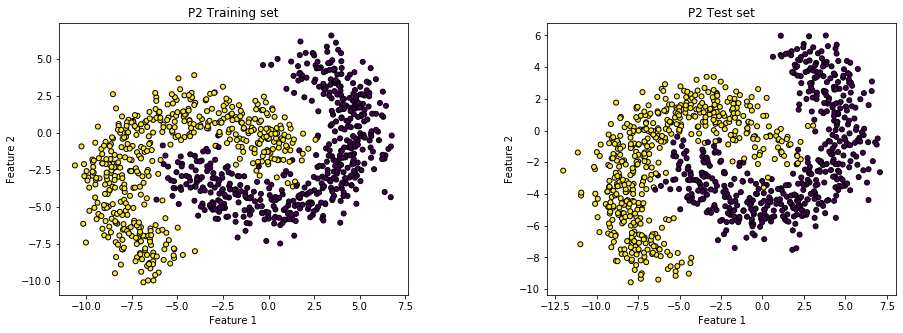

In [22]:
# Generating and plotting the P2 Dataset:
rng = np.random.RandomState(1234)
X, y = make_banana2([1000, 1000], random_state=rng)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,
                                                    random_state=rng)
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plot_dataset(X_train, y_train, ax=axs[0], title='P2 Training set')
plot_dataset(X_test, y_test, ax=axs[1], title='P2 Test set')

In [23]:
models = 5
depth = 4

local_models = 8
local_depth = 2

In [24]:
pool_classifiers = AdaBoostClassifier(DecisionTreeClassifier(max_depth=depth), n_estimators=models)
pool_classifiers.fit(X_train, y_train)

ola = OLA(pool_classifiers)
mcb = MCB(pool_classifiers)
apriori = APriori(pool_classifiers)
lca = LCA(pool_classifiers)


gon = GON(pool_classifiers=[DecisionTreeClassifier(max_depth=depth) for i in range(models)], 
          step_size=2., 
          iterations=40, 
          mode='global',
          step_callback=None)


# DES techniques
knorau = KNORAU(pool_classifiers)
kne = KNORAE(pool_classifiers)
desp = DESP(pool_classifiers)
meta = METADES(pool_classifiers)

# Standard Techs
rf = RandomForestClassifier(max_depth=depth, n_estimators=models)
gb = GradientBoostingClassifier(max_depth=depth, n_estimators=models)

In [25]:
knorau.fit(X_train, y_train)
kne.fit(X_train, y_train)
desp.fit(X_train, y_train)
ola.fit(X_train, y_train)
mcb.fit(X_train, y_train)
apriori.fit(X_train, y_train)
meta.fit(X_train, y_train)
lca.fit(X_train, y_train)
gon.fit(X_train, y_train) # we use no separate set to train and select
rf.fit(X_train, y_train)
_ = gb.fit(X_train, y_train)

In [26]:
print('Classification accuracy OLA: ', ola.score(X_test, y_test))
print('Classification accuracy A priori: ', apriori.score(X_test, y_test))
print('Classification accuracy KNORA-Union: ', knorau.score(X_test, y_test))
print('Classification accuracy KNORA-Eliminate: ', kne.score(X_test, y_test))
print('Classification accuracy DESP: ', desp.score(X_test, y_test))
print('Classification accuracy META-DES: ', apriori.score(X_test, y_test))
print('Classification accuracy LCA: ', lca.score(X_test, y_test))
print('Classification accuracy GON: ', gon.score(X_test, y_test))
print('Classification accuracy RF: ', rf.score(X_test, y_test))
print('Classification accuracy GB: ', gb.score(X_test, y_test))

Classification accuracy OLA:  0.962
Classification accuracy A priori:  0.961
Classification accuracy KNORA-Union:  0.969
Classification accuracy KNORA-Eliminate:  0.961
Classification accuracy DESP:  0.965
Classification accuracy META-DES:  0.962
Classification accuracy LCA:  0.969
Classification accuracy GON:  0.964
Classification accuracy RF:  0.957
Classification accuracy GB:  0.947


In [27]:
oracle_apriori = Oracle(apriori.pool_classifiers_)
oracle_ola = Oracle(ola.pool_classifiers_)
oracle_lca = Oracle(lca.pool_classifiers_)
oracle_knorau = Oracle(knorau.pool_classifiers_)
oracle_kne = Oracle(kne.pool_classifiers_)
oracle_meta = Oracle(meta.pool_classifiers_)
oracle_gon = Oracle(gon.pool_classifiers_)

oracle_rf = Oracle(rf.estimators_)
oracle_gb = Oracle(gb.estimators_)

oracle_apriori.fit(X_train, y_train)
oracle_knorau.fit(X_train, y_train)
oracle_ola.fit(X_train, y_train)
oracle_lca.fit(X_train, y_train)
oracle_kne.fit(X_train, y_train)
oracle_gon.fit(X_train, y_train)
oracle_meta.fit(X_train, y_train)
oracle_gb.fit(X_train, y_train)
_ = oracle_rf.fit(X_train, y_train)

In [28]:
print('Classification accuracy A priori oracle: ', oracle_apriori.score(X_test, y_test))
print('Classification accuracy OLA oracle: ', oracle_ola.score(X_test, y_test))
print('Classification accuracy Knorau oracle: ', oracle_knorau.score(X_test, y_test))
print('Classification accuracy LCA oracle: ', oracle_lca.score(X_test, y_test))
print('Classification accuracy KNE oracle: ', oracle_kne.score(X_test, y_test))
print('Classification accuracy META oracle: ', oracle_meta.score(X_test, y_test))
print('Classification accuracy GON oracle: ', oracle_gon.score(X_test, y_test))
print('Classification accuracy RF oracle: ', oracle_rf.score(X_test, y_test))
#print('Classification accuracy GB oracle: ', oracle_gb.score(X_test, y_test))

Classification accuracy A priori oracle:  0.998
Classification accuracy OLA oracle:  0.998
Classification accuracy Knorau oracle:  0.998
Classification accuracy LCA oracle:  0.998
Classification accuracy KNE oracle:  0.998
Classification accuracy META oracle:  0.998
Classification accuracy GON oracle:  0.996
Classification accuracy RF oracle:  0.99


In [29]:
scatter = ScatterVideoCreatorGON(False)
gon_local = GON(pool_classifiers=[DecisionTreeClassifier(max_depth=local_depth) for i in range(local_models)], 
          step_size=2, 
          iterations=30, 
          mode='local',
          step_callback=scatter)

gon_local.fit(X_train, y_train)

MovieWriter ffmpeg unavailable; trying to use <class 'matplotlib.animation.HTMLWriter'> instead.


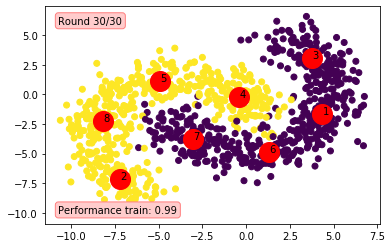

In [30]:
_ = scatter.as_video("./banana2.html", 
                     scatter.draw_animation(interval=300))

with open('./banana2.html', 'r') as fp:
    data = fp.read()

HTML(data)
#HTML(data)

## P2

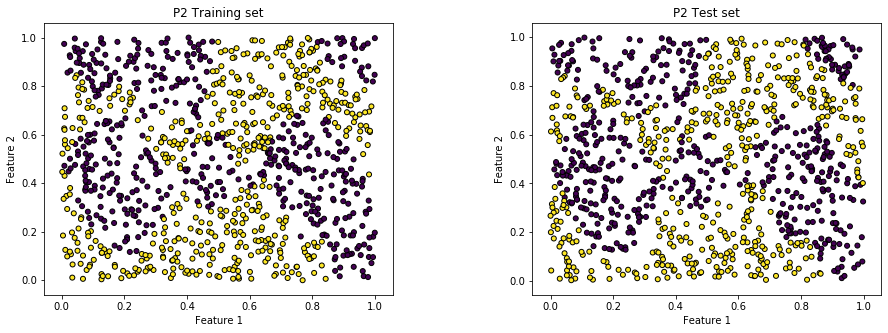

In [31]:
# Generating and plotting the P2 Dataset:
rng = np.random.RandomState(1234)
X, y = make_P2([1000, 1000], random_state=rng)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,
                                                    random_state=rng)
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plot_dataset(X_train, y_train, ax=axs[0], title='P2 Training set')
plot_dataset(X_test, y_test, ax=axs[1], title='P2 Test set')

In [32]:
pool_classifiers = AdaBoostClassifier(DecisionTreeClassifier(max_depth=depth), n_estimators=models)
pool_classifiers.fit(X_train, y_train)

ola = OLA(pool_classifiers)
mcb = MCB(pool_classifiers)
apriori = APriori(pool_classifiers)
lca = LCA(pool_classifiers)


gon = GON(pool_classifiers=[DecisionTreeClassifier(max_depth=depth) for i in range(models)], 
          step_size=2., 
          iterations=40, 
          mode='global',
          step_callback=None)


# DES techniques
knorau = KNORAU(pool_classifiers)
kne = KNORAE(pool_classifiers)
desp = DESP(pool_classifiers)
meta = METADES(pool_classifiers)

# Standard Techs
rf = RandomForestClassifier(max_depth=depth, n_estimators=models)
gb = GradientBoostingClassifier(max_depth=depth, n_estimators=models)

In [33]:
knorau.fit(X_train, y_train)
kne.fit(X_train, y_train)
desp.fit(X_train, y_train)
ola.fit(X_train, y_train)
mcb.fit(X_train, y_train)
apriori.fit(X_train, y_train)
meta.fit(X_train, y_train)
lca.fit(X_train, y_train)
gon.fit(X_train, y_train) # we use no separate set to train and select
rf.fit(X_train, y_train)
_ = gb.fit(X_train, y_train)

In [34]:
print('Classification accuracy OLA: ', ola.score(X_test, y_test))
print('Classification accuracy A priori: ', apriori.score(X_test, y_test))
print('Classification accuracy KNORA-Union: ', knorau.score(X_test, y_test))
print('Classification accuracy KNORA-Eliminate: ', kne.score(X_test, y_test))
print('Classification accuracy DESP: ', desp.score(X_test, y_test))
print('Classification accuracy META-DES: ', apriori.score(X_test, y_test))
print('Classification accuracy LCA: ', lca.score(X_test, y_test))
print('Classification accuracy GON: ', gon.score(X_test, y_test))
print('Classification accuracy RF: ', rf.score(X_test, y_test))
print('Classification accuracy GB: ', gb.score(X_test, y_test))

Classification accuracy OLA:  0.939
Classification accuracy A priori:  0.937
Classification accuracy KNORA-Union:  0.921
Classification accuracy KNORA-Eliminate:  0.942
Classification accuracy DESP:  0.931
Classification accuracy META-DES:  0.939
Classification accuracy LCA:  0.863
Classification accuracy GON:  0.89
Classification accuracy RF:  0.759
Classification accuracy GB:  0.77


In [35]:
oracle_apriori = Oracle(apriori.pool_classifiers_)
oracle_ola = Oracle(ola.pool_classifiers_)
oracle_lca = Oracle(lca.pool_classifiers_)
oracle_knorau = Oracle(knorau.pool_classifiers_)
oracle_kne = Oracle(kne.pool_classifiers_)
oracle_meta = Oracle(meta.pool_classifiers_)
oracle_gon = Oracle(gon.pool_classifiers_)

oracle_rf = Oracle(rf.estimators_)
oracle_gb = Oracle(gb.estimators_)

oracle_apriori.fit(X_train, y_train)
oracle_knorau.fit(X_train, y_train)
oracle_ola.fit(X_train, y_train)
oracle_lca.fit(X_train, y_train)
oracle_kne.fit(X_train, y_train)
oracle_gon.fit(X_train, y_train)
oracle_meta.fit(X_train, y_train)
oracle_gb.fit(X_train, y_train)
_ = oracle_rf.fit(X_train, y_train)

In [36]:
print('Classification accuracy A priori oracle: ', oracle_apriori.score(X_test, y_test))
print('Classification accuracy OLA oracle: ', oracle_ola.score(X_test, y_test))
print('Classification accuracy Knorau oracle: ', oracle_knorau.score(X_test, y_test))
print('Classification accuracy LCA oracle: ', oracle_lca.score(X_test, y_test))
print('Classification accuracy KNE oracle: ', oracle_kne.score(X_test, y_test))
print('Classification accuracy META oracle: ', oracle_meta.score(X_test, y_test))
print('Classification accuracy GON oracle: ', oracle_gon.score(X_test, y_test))
print('Classification accuracy RF oracle: ', oracle_rf.score(X_test, y_test))
#print('Classification accuracy GB oracle: ', oracle_gb.score(X_test, y_test))

Classification accuracy A priori oracle:  0.999
Classification accuracy OLA oracle:  0.999
Classification accuracy Knorau oracle:  0.999
Classification accuracy LCA oracle:  0.999
Classification accuracy KNE oracle:  0.999
Classification accuracy META oracle:  0.999
Classification accuracy GON oracle:  0.981
Classification accuracy RF oracle:  0.983


In [37]:
scatter = ScatterVideoCreatorGON(False)
gon_local = GON(pool_classifiers=[DecisionTreeClassifier(max_depth=local_depth) for i in range(local_models)], 
          step_size=2, 
          iterations=30, 
          mode='local',
          step_callback=scatter)

gon_local.fit(X_train, y_train)

MovieWriter ffmpeg unavailable; trying to use <class 'matplotlib.animation.HTMLWriter'> instead.


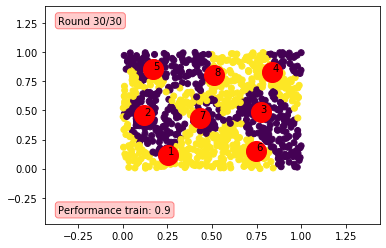

In [38]:
_ = scatter.as_video("./p2.html", 
                     scatter.draw_animation(interval=300))

with open('./p2.html', 'r') as fp:
    data = fp.read()

HTML(data)


## circle square

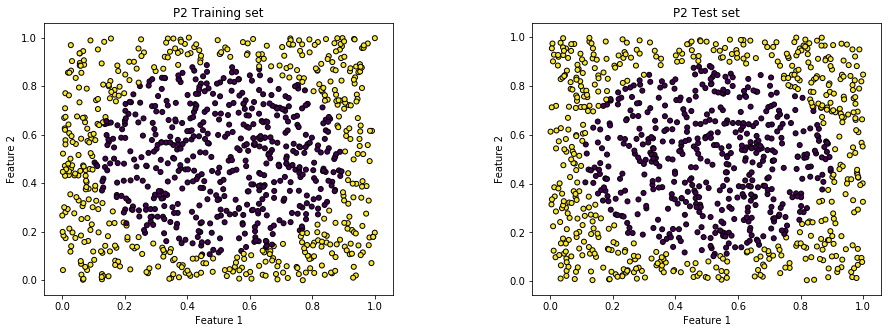

In [39]:
# Generating and plotting the P2 Dataset:
rng = np.random.RandomState(1234)
X, y = make_circle_square([1000, 1000], random_state=rng)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,
                                                    random_state=rng)
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plot_dataset(X_train, y_train, ax=axs[0], title='P2 Training set')
plot_dataset(X_test, y_test, ax=axs[1], title='P2 Test set')

In [40]:
pool_classifiers = AdaBoostClassifier(DecisionTreeClassifier(max_depth=depth), n_estimators=models)
pool_classifiers.fit(X_train, y_train)

ola = OLA(pool_classifiers)
mcb = MCB(pool_classifiers)
apriori = APriori(pool_classifiers)
lca = LCA(pool_classifiers)


gon = GON(pool_classifiers=[DecisionTreeClassifier(max_depth=depth) for i in range(models)], 
          step_size=2., 
          iterations=40, 
          mode='global',
          step_callback=None)


# DES techniques
knorau = KNORAU(pool_classifiers)
kne = KNORAE(pool_classifiers)
desp = DESP(pool_classifiers)
meta = METADES(pool_classifiers)

# Standard Techs
rf = RandomForestClassifier(max_depth=depth, n_estimators=models)
gb = GradientBoostingClassifier(max_depth=depth, n_estimators=models)

In [41]:
knorau.fit(X_train, y_train)
kne.fit(X_train, y_train)
desp.fit(X_train, y_train)
ola.fit(X_train, y_train)
mcb.fit(X_train, y_train)
apriori.fit(X_train, y_train)
meta.fit(X_train, y_train)
lca.fit(X_train, y_train)
gon.fit(X_train, y_train) # we use no separate set to train and select
rf.fit(X_train, y_train)
_ = gb.fit(X_train, y_train)

In [42]:
print('Classification accuracy OLA: ', ola.score(X_test, y_test))
print('Classification accuracy A priori: ', apriori.score(X_test, y_test))
print('Classification accuracy KNORA-Union: ', knorau.score(X_test, y_test))
print('Classification accuracy KNORA-Eliminate: ', kne.score(X_test, y_test))
print('Classification accuracy DESP: ', desp.score(X_test, y_test))
print('Classification accuracy META-DES: ', apriori.score(X_test, y_test))
print('Classification accuracy LCA: ', lca.score(X_test, y_test))
print('Classification accuracy GON: ', gon.score(X_test, y_test))
print('Classification accuracy RF: ', rf.score(X_test, y_test))
print('Classification accuracy GB: ', gb.score(X_test, y_test))

Classification accuracy OLA:  0.967
Classification accuracy A priori:  0.969
Classification accuracy KNORA-Union:  0.962
Classification accuracy KNORA-Eliminate:  0.972
Classification accuracy DESP:  0.957
Classification accuracy META-DES:  0.972
Classification accuracy LCA:  0.93
Classification accuracy GON:  0.959
Classification accuracy RF:  0.883
Classification accuracy GB:  0.902


In [43]:
oracle_apriori = Oracle(apriori.pool_classifiers_)
oracle_ola = Oracle(ola.pool_classifiers_)
oracle_lca = Oracle(lca.pool_classifiers_)
oracle_knorau = Oracle(knorau.pool_classifiers_)
oracle_kne = Oracle(kne.pool_classifiers_)
oracle_meta = Oracle(meta.pool_classifiers_)
oracle_gon = Oracle(gon.pool_classifiers_)

oracle_rf = Oracle(rf.estimators_)
oracle_gb = Oracle(gb.estimators_)

oracle_apriori.fit(X_train, y_train)
oracle_knorau.fit(X_train, y_train)
oracle_ola.fit(X_train, y_train)
oracle_lca.fit(X_train, y_train)
oracle_kne.fit(X_train, y_train)
oracle_gon.fit(X_train, y_train)
oracle_meta.fit(X_train, y_train)
oracle_gb.fit(X_train, y_train)
_ = oracle_rf.fit(X_train, y_train)

In [44]:
print('Classification accuracy A priori oracle: ', oracle_apriori.score(X_test, y_test))
print('Classification accuracy OLA oracle: ', oracle_ola.score(X_test, y_test))
print('Classification accuracy Knorau oracle: ', oracle_knorau.score(X_test, y_test))
print('Classification accuracy LCA oracle: ', oracle_lca.score(X_test, y_test))
print('Classification accuracy KNE oracle: ', oracle_kne.score(X_test, y_test))
print('Classification accuracy META oracle: ', oracle_meta.score(X_test, y_test))
print('Classification accuracy GON oracle: ', oracle_gon.score(X_test, y_test))
print('Classification accuracy RF oracle: ', oracle_rf.score(X_test, y_test))
#print('Classification accuracy GB oracle: ', oracle_gb.score(X_test, y_test))

Classification accuracy A priori oracle:  0.998
Classification accuracy OLA oracle:  0.998
Classification accuracy Knorau oracle:  0.998
Classification accuracy LCA oracle:  0.998
Classification accuracy KNE oracle:  0.998
Classification accuracy META oracle:  0.998
Classification accuracy GON oracle:  0.984
Classification accuracy RF oracle:  0.987


In [45]:
scatter = ScatterVideoCreatorGON(False)
gon_local = GON(pool_classifiers=[DecisionTreeClassifier(max_depth=local_depth) for i in range(local_models)], 
          step_size=2, 
          iterations=30, 
          mode='local',
          step_callback=scatter)

gon_local.fit(X_train, y_train)

MovieWriter ffmpeg unavailable; trying to use <class 'matplotlib.animation.HTMLWriter'> instead.


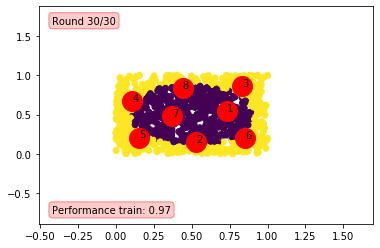

In [46]:
_ = scatter.as_video("./circle.html", 
                     scatter.draw_animation(interval=300))

with open('./circle.html', 'r') as fp:
    data = fp.read()

HTML(data)


## banana 1

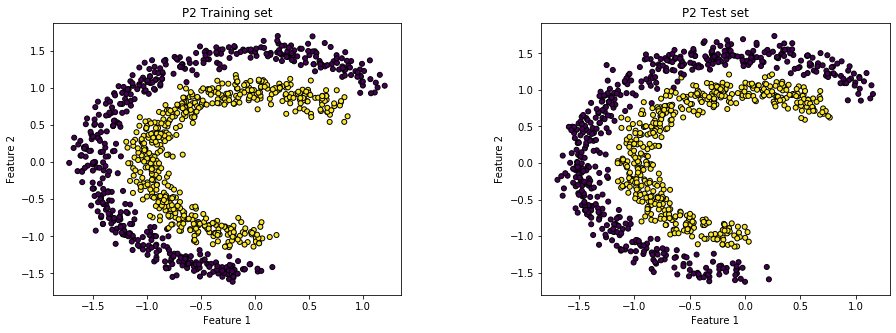

In [47]:
# Generating and plotting the P2 Dataset:
rng = np.random.RandomState(1234)
X, y = make_banana([1000, 1000], random_state=rng)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,
                                                    random_state=rng)
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plot_dataset(X_train, y_train, ax=axs[0], title='P2 Training set')
plot_dataset(X_test, y_test, ax=axs[1], title='P2 Test set')

In [48]:
pool_classifiers = AdaBoostClassifier(DecisionTreeClassifier(max_depth=depth), n_estimators=models)
pool_classifiers.fit(X_train, y_train)

ola = OLA(pool_classifiers)
mcb = MCB(pool_classifiers)
apriori = APriori(pool_classifiers)
lca = LCA(pool_classifiers)


gon = GON(pool_classifiers=[DecisionTreeClassifier(max_depth=depth) for i in range(models)], 
          step_size=2., 
          iterations=40, 
          mode='global',
          step_callback=None)


# DES techniques
knorau = KNORAU(pool_classifiers)
kne = KNORAE(pool_classifiers)
desp = DESP(pool_classifiers)
meta = METADES(pool_classifiers)

# Standard Techs
rf = RandomForestClassifier(max_depth=depth, n_estimators=models)
gb = GradientBoostingClassifier(max_depth=depth, n_estimators=models)

In [49]:
knorau.fit(X_train, y_train)
kne.fit(X_train, y_train)
desp.fit(X_train, y_train)
ola.fit(X_train, y_train)
mcb.fit(X_train, y_train)
apriori.fit(X_train, y_train)
meta.fit(X_train, y_train)
lca.fit(X_train, y_train)
gon.fit(X_train, y_train) # we use no separate set to train and select
rf.fit(X_train, y_train)
_ = gb.fit(X_train, y_train)

In [50]:
print('Classification accuracy OLA: ', ola.score(X_test, y_test))
print('Classification accuracy A priori: ', apriori.score(X_test, y_test))
print('Classification accuracy KNORA-Union: ', knorau.score(X_test, y_test))
print('Classification accuracy KNORA-Eliminate: ', kne.score(X_test, y_test))
print('Classification accuracy DESP: ', desp.score(X_test, y_test))
print('Classification accuracy META-DES: ', apriori.score(X_test, y_test))
print('Classification accuracy LCA: ', lca.score(X_test, y_test))
print('Classification accuracy GON: ', gon.score(X_test, y_test))
print('Classification accuracy RF: ', rf.score(X_test, y_test))
print('Classification accuracy GB: ', gb.score(X_test, y_test))

Classification accuracy OLA:  0.982
Classification accuracy A priori:  0.993
Classification accuracy KNORA-Union:  0.988
Classification accuracy KNORA-Eliminate:  0.991
Classification accuracy DESP:  0.988
Classification accuracy META-DES:  0.987
Classification accuracy LCA:  0.989
Classification accuracy GON:  0.98
Classification accuracy RF:  0.96
Classification accuracy GB:  0.957


In [51]:
oracle_apriori = Oracle(apriori.pool_classifiers_)
oracle_ola = Oracle(ola.pool_classifiers_)
oracle_lca = Oracle(lca.pool_classifiers_)
oracle_knorau = Oracle(knorau.pool_classifiers_)
oracle_kne = Oracle(kne.pool_classifiers_)
oracle_meta = Oracle(meta.pool_classifiers_)
oracle_gon = Oracle(gon.pool_classifiers_)

oracle_rf = Oracle(rf.estimators_)
oracle_gb = Oracle(gb.estimators_)

oracle_apriori.fit(X_train, y_train)
oracle_knorau.fit(X_train, y_train)
oracle_ola.fit(X_train, y_train)
oracle_lca.fit(X_train, y_train)
oracle_kne.fit(X_train, y_train)
oracle_gon.fit(X_train, y_train)
oracle_meta.fit(X_train, y_train)
oracle_gb.fit(X_train, y_train)
_ = oracle_rf.fit(X_train, y_train)

In [52]:
print('Classification accuracy A priori oracle: ', oracle_apriori.score(X_test, y_test))
print('Classification accuracy OLA oracle: ', oracle_ola.score(X_test, y_test))
print('Classification accuracy Knorau oracle: ', oracle_knorau.score(X_test, y_test))
print('Classification accuracy LCA oracle: ', oracle_lca.score(X_test, y_test))
print('Classification accuracy KNE oracle: ', oracle_kne.score(X_test, y_test))
print('Classification accuracy META oracle: ', oracle_meta.score(X_test, y_test))
print('Classification accuracy GON oracle: ', oracle_gon.score(X_test, y_test))
print('Classification accuracy RF oracle: ', oracle_rf.score(X_test, y_test))
#print('Classification accuracy GB oracle: ', oracle_gb.score(X_test, y_test))

Classification accuracy A priori oracle:  0.999
Classification accuracy OLA oracle:  0.999
Classification accuracy Knorau oracle:  0.999
Classification accuracy LCA oracle:  0.999
Classification accuracy KNE oracle:  0.999
Classification accuracy META oracle:  0.999
Classification accuracy GON oracle:  0.993
Classification accuracy RF oracle:  0.974


In [53]:
scatter = ScatterVideoCreatorGON(False)
gon_local = GON(pool_classifiers=[DecisionTreeClassifier(max_depth=local_depth) for i in range(local_models)], 
          step_size=2, 
          iterations=30, 
          mode='local',
          step_callback=scatter)

gon_local.fit(X_train, y_train)

MovieWriter ffmpeg unavailable; trying to use <class 'matplotlib.animation.HTMLWriter'> instead.


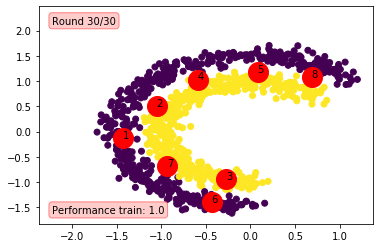

In [54]:
_ = scatter.as_video("./banana1.html", 
                     scatter.draw_animation(interval=300))

with open('./banana1.html', 'r') as fp:
    data = fp.read()

HTML(data)
